In [1]:
!pip install ipywidgets

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from itertools import product
import matplotlib.pyplot as plt
import networkx as nx
import heapq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00


In [2]:
people_df = pd.read_csv("/content/People_and_Ranks.csv")
halls_df = pd.read_csv("/content/Halls_and_Chair_Counts.csv")

In [7]:
hall_dropdown = widgets.Dropdown(
    options=halls_df["اسم القاعة"].tolist(),
    description='اختر القاعة:',
    layout=widgets.Layout(width='50%')
)

people_select = widgets.SelectMultiple(
    options=[],
    description='الأشخاص:',
    layout=widgets.Layout(width='50%', height='250px')
)

confirm_button = widgets.Button(
    description='ابدأ الترتيب',
    button_style='success'
)

output = widgets.Output()

people_checkboxes = []
people_box = widgets.VBox()

def update_people(change):
    selected = change.new
    max_chairs = int(halls_df[halls_df["اسم القاعة"] == selected]["عدد الكراسي"].values[0])
    people_checkboxes.clear()

    for name in people_df["الاسم"].tolist():
        cb = widgets.Checkbox(value=False, description=name)
        people_checkboxes.append(cb)

    people_box.children = people_checkboxes

    with output:
        clear_output()
        print(f" يمكنك اختيار حتى {max_chairs} شخصًا من القائمة.")
    with output:
        clear_output()
        print(f" يمكنك اختيار حتى {max_chairs} شخصًا من القائمة.")
def run_logic(button):
    selected_hall = hall_dropdown.value
    max_chairs = int(halls_df[halls_df["اسم القاعة"] == selected_hall]["عدد الكراسي"].values[0])

    selected_names = [cb.description for cb in people_checkboxes if cb.value]

    with output:
        clear_output()
        if len(selected_names) == 0:
            print(" الرجاء اختيار الأشخاص.")
        elif len(selected_names) > max_chairs:
            print(f" لا يمكنك اختيار أكثر من {max_chairs} شخصًا.")
        else:
            print(f" القاعة: {selected_hall}")
            print(" الأشخاص:")
            for name in selected_names:
                print("•", name)

            global selected_people, df_dislike
            selected_people = people_df[people_df["الاسم"].isin(selected_names)]
            rank_dict = dict(zip(selected_people["الاسم"], selected_people["رتبة"]))
            dislike_matrix = {
                n1: {n2: abs(rank_dict[n1] - rank_dict[n2]) for n2 in selected_names}
                for n1 in selected_names
            }
            df_dislike = pd.DataFrame(dislike_matrix)
            print("\n مصفوفة التنافر:")
            display(df_dislike)
hall_dropdown.observe(update_people, names='value')
confirm_button.on_click(run_logic)

display(hall_dropdown, people_box, confirm_button, output)

Dropdown(description='اختر القاعة:', layout=Layout(width='50%'), options=('قاعة مكة', 'قاعة الرياض', 'قاعة الم…

VBox()

Button(button_style='success', description='ابدأ الترتيب', style=ButtonStyle())

Output()

In [8]:
def total_cost_from_path(path, graph):
    total_cost = 0.0
    if len(path) == 0:
        return None
    for i in range(len(path)):
        p1 = path[i]
        p2 = path[(i + 1) % len(path)]  # دائري
        if graph.has_edge(p1, p2):
            total_cost += graph[p1][p2]['weight']
    return total_cost

def uniform_cost_search(graph):
    min_cost = float('inf')
    optimal_path = None
    individuals = list(graph.nodes)
    if not individuals:
        return None, None
    queue = []
    heapq.heappush(queue, (0, [individuals[0]]))
    while queue:
        current_cost, current_path = heapq.heappop(queue)
        current_node = current_path[-1]
        if len(current_path) == len(individuals):
            if graph.has_edge(current_path[0], current_node):
                total = total_cost_from_path(current_path, graph)
                if total < min_cost:
                    min_cost = total
                    optimal_path = current_path
            continue
        for neighbor in graph.neighbors(current_node):
            if neighbor not in current_path:
                new_path = current_path + [neighbor]
                cost = total_cost_from_path(new_path, graph)
                heapq.heappush(queue, (cost, new_path))
    return optimal_path, min_cost

def greedy_search(graph):
    individuals = list(graph.nodes)
    if not individuals:
        return None, None
    current_node = individuals[0]
    path = [current_node]
    visited = {current_node}
    while len(path) < len(individuals):
        best_cost = float('inf')
        best_next = None
        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                temp_path = path + [neighbor]
                cost = total_cost_from_path(temp_path, graph)
                if cost < best_cost:
                    best_cost = cost
                    best_next = neighbor
        if best_next is None:
            break
        path.append(best_next)
        visited.add(best_next)
        current_node = best_next
    if len(path) == len(individuals) and graph.has_edge(path[0], path[-1]):
        return path, total_cost_from_path(path, graph)
    return None, None

def visualize_round_table_with_numbers(arrangement, title):
    G = nx.cycle_graph(len(arrangement))
    pos = nx.circular_layout(G)

    node_labels = {i: str(i + 1) for i in range(len(arrangement))}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=2000, font_size=12)
    plt.title(title)
    plt.axis('off')
    plt.show()

    # جدول يوضح الأرقام مع الأسماء
    print(" توزيع الأرقام على الأسماء:")
    for i, name in enumerate(arrangement):
        print(f"{i+1}. {name}")

 UCS الترتيب الأفضل: ['سلمان بن عبدالعزيز', 'سعود بن مشعل', 'محمد بن عبدالعزيز بن محمد', 'سعود بن نايف', 'فيصل بن سلمان', 'فيصل بن مشعل', 'محمد بن ناصر', 'محمد بن سلمان']
 الكلفة: 6.0


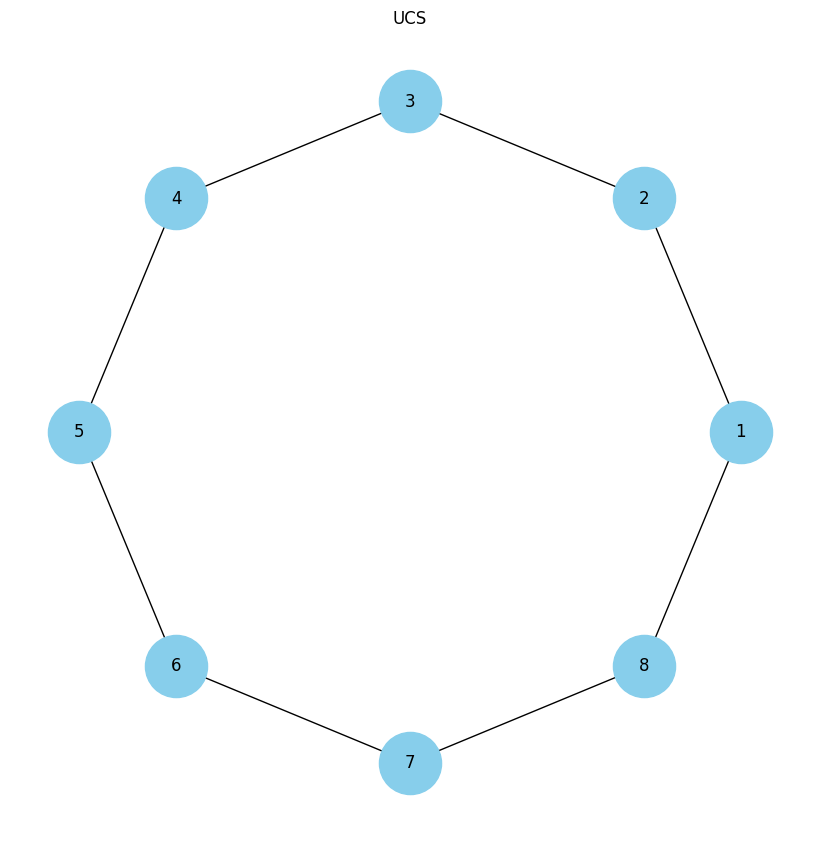

 توزيع الأرقام على الأسماء:
1. سلمان بن عبدالعزيز
2. سعود بن مشعل
3. محمد بن عبدالعزيز بن محمد
4. سعود بن نايف
5. فيصل بن سلمان
6. فيصل بن مشعل
7. محمد بن ناصر
8. محمد بن سلمان
 Greedy الترتيب الأفضل: ['سلمان بن عبدالعزيز', 'محمد بن سلمان', 'فيصل بن سلمان', 'فيصل بن مشعل', 'محمد بن ناصر', 'سعود بن نايف', 'سعود بن مشعل', 'محمد بن عبدالعزيز بن محمد']
 الكلفة: 6.0


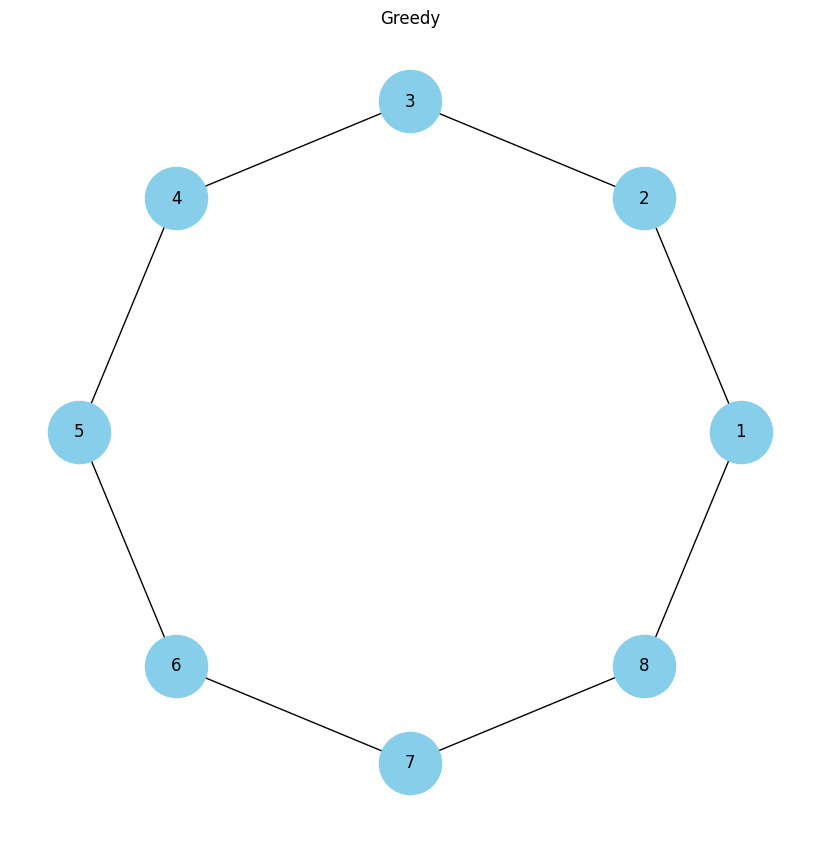

 توزيع الأرقام على الأسماء:
1. سلمان بن عبدالعزيز
2. محمد بن سلمان
3. فيصل بن سلمان
4. فيصل بن مشعل
5. محمد بن ناصر
6. سعود بن نايف
7. سعود بن مشعل
8. محمد بن عبدالعزيز بن محمد


In [9]:

G = nx.Graph()
for i in df_dislike.index:
    for j in df_dislike.columns:
        if i != j:
            G.add_edge(i, j, weight=df_dislike.loc[i, j])

ucs_result, ucs_cost = uniform_cost_search(G)
print(" UCS الترتيب الأفضل:", ucs_result)
print(" الكلفة:", ucs_cost)
visualize_round_table_with_numbers(ucs_result, "UCS")

greedy_result, greedy_cost = greedy_search(G)
print(" Greedy الترتيب الأفضل:", greedy_result)
print(" الكلفة:", greedy_cost)
visualize_round_table_with_numbers(greedy_result, "Greedy")